In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import os


In [5]:
train_dir = "/kaggle/input/traindataset/train"
val_dir = "/kaggle/input/valdataset/val"
test_dir = "/kaggle/input/testdataset/test"

In [6]:
# Load with categorical labels (one-hot)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Print to verify
print("Classes:", train_ds.class_names)


Found 6051 files belonging to 5 classes.


I0000 00:00:1745572688.640737      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2016 files belonging to 5 classes.
Found 2025 files belonging to 5 classes.
Classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [9]:
from tensorflow.keras import layers

# This is only applied to the training dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Rescale pixel values [0, 255] → [0, 1]
normalization_layer = layers.Rescaling(1./255)


In [10]:
def preprocess_dataset(dataset, augment=False):
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y))
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
train_ds = preprocess_dataset(train_ds, augment=True)
val_ds = preprocess_dataset(val_ds)
test_ds = preprocess_dataset(test_ds)


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  # for multi-class classification
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model()
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # You can start with 10 and increase based on time
)


Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 392ms/step - accuracy: 0.8403 - loss: 0.3780 - val_accuracy: 0.7624 - val_loss: 0.5637
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 72s 375ms/step - accuracy: 0.8398 - loss: 0.3731 - val_accuracy: 0.7465 - val_loss: 0.5731
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 368ms/step - accuracy: 0.8303 - loss: 0.3827 - val_accuracy: 0.7034 - val_loss: 0.6847
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 369ms/step - accuracy: 0.8370 - loss: 0.3801 - val_accuracy: 0.7450 - val_loss: 0.5628
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 368ms/step - accuracy: 0.8467 - loss: 0.3505 - val_accuracy: 0.7307 - val_loss: 0.6164
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 368ms/step - accuracy: 0.8489 - loss: 0.3676 - val_accuracy: 0.7679 - val_loss: 0.5172
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 70s 368ms/step - accuracy: 0.8438 - loss: 0.3614 - val_accuracy: 0.7560 - val_loss: 0.5467
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 69s 364ms/step - accuracy: 0.8426 - loss: 0

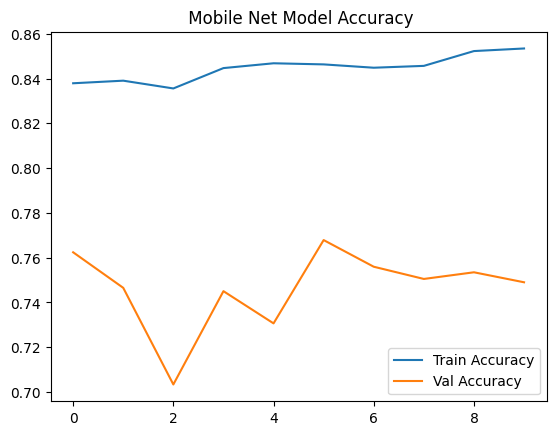

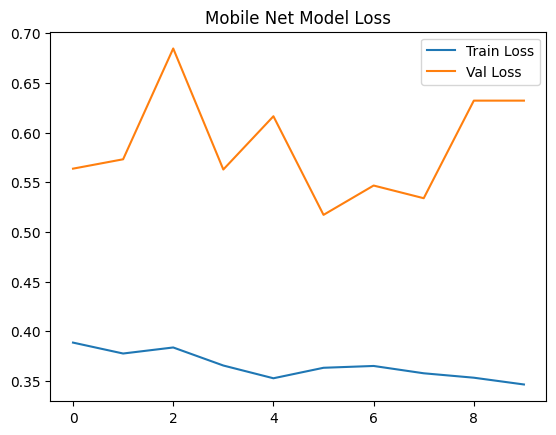

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title(" Mobile Net Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Mobile Net Model Loss")
plt.show()


In [30]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7763 - loss: 0.5694
Test Accuracy: 0.76


In [31]:
import numpy as np

# Get predictions from test dataset
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)


64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step


In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,)
class_names = train_ds.class_names

Found 6051 files belonging to 5 classes.


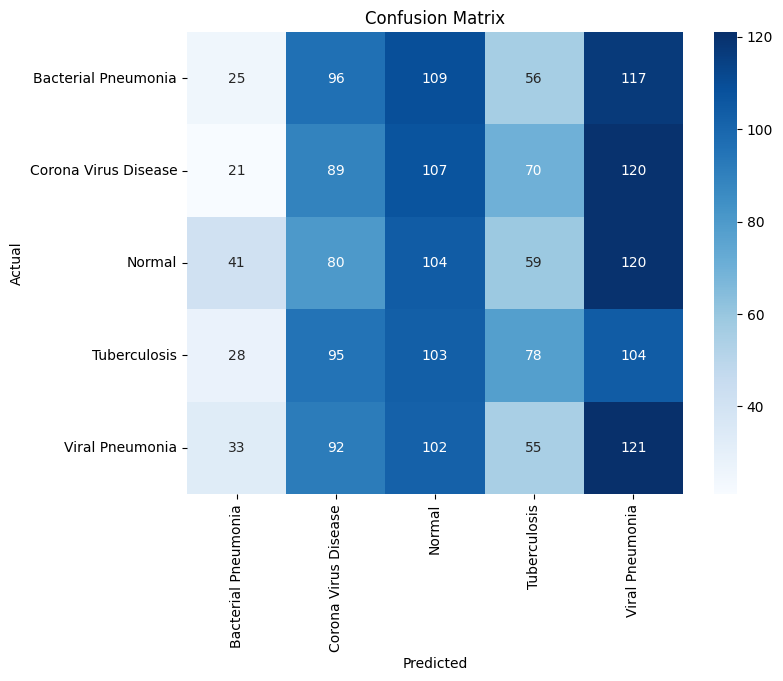

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.17      0.06      0.09       403
Corona Virus Disease       0.20      0.22      0.21       407
              Normal       0.20      0.26      0.22       404
        Tuberculosis       0.25      0.19      0.21       408
     Viral Pneumonia       0.21      0.30      0.25       403

            accuracy                           0.21      2025
           macro avg       0.20      0.21      0.20      2025
        weighted avg       0.20      0.21      0.20      2025



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [35]:
# Save model in H5 format
model.save('lung_disease_model.h5')
